# Sheet 2: Least-squares and Maximum-likelihood Estimators

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from iminuit import Minuit
from resample.bootstrap import variance
from scipy.optimize import minimize

rng = np.random.default_rng(seed=1)

---

## Task 1: Least-Squares Method Analytically 

Given are 10 value pairs $(k, y_k)$ for $k$ from 1 to 10, where the $y_k$ are Poisson-distributed measurements around expectation values $\mu_k = a\cdot k$.   
The parameter $a$ is to be estimated using the weighted least-squares method. To do this, consider the following $\chi^2$ functions:

$$\chi^2 = \sum_{k=1}^{10} w_k (y_k - \mu_k)^2 \quad\text{with}\quad w_k \in \left\{1, \frac{1}{y_k}, \frac{1}{\mu_k} \right\}$$

### 1.1

Analytically calculate the estimators $\hat{a}$ as a function of the $y_k$ which minimize the corresponding $\chi^2$ functions. Are there special cases where the estimators are not defined?

---

---
### 1.2

Compute the distributions of the estimators $\hat{a}$ using Monte-Carlo simulation for $a = 1$ and $a = 100$. Which estimator has the smallest bias and variance?

---

---

## Task 2: Least-Squares Method

We will now use the least-squares method to calculate an estimator for the parameters of probability density functions.   
In practice, calculating analytical derivatives is often not feasible, so we will use a numerical minimization tool.

We consider a histogram with 50 Bins in the range $[0,1]$.
* We generate two poisson distributed random numbers $N_s$ and $N_b$ each with the expectation value 100.
* We draw $N_b$ uniformly distributed numbers $b_i$ between 0 and 1.
* We draw $N_s$ normally distributed numbers $s_i$ with $\mu = 0.5$ and $\sigma=0.05$.
* We fill the histogram with the two samples $\{b_i\}$ and $\{s_i\}$.

---

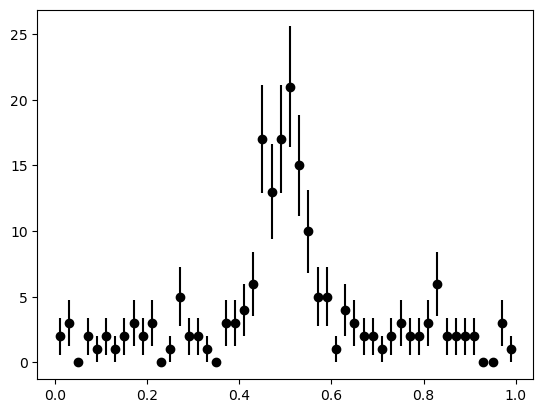

In [6]:
def generate(rng, mu, sigma):
    ns, nb = rng.poisson(100, size=2)
    b = rng.uniform(0, 1, size=nb)
    s = rng.normal(mu, sigma, size=ns)
    x = np.append(s, b)
    return x


def generate_histogram(x):
    ntot = len(x)
    n, xe = np.histogram(x, range=(0, 1), bins=50)
    return ntot, n, xe


mu_true = 0.5
sigma_true = 0.05

x = generate(rng, mu_true, sigma_true)
ntot, n, xe = generate_histogram(x)

cx = 0.5 * (xe[1:] + xe[:-1])
plt.errorbar(cx, n, n**0.5, fmt="ok");

---

### 2.1

What is the probability density function for this scenario?

_Hint_: The probability density function must be normalized to unity, and it is a mixture of two common distributions.

---

The probability density function is

$$
\rho(x; f_s, \mu, \sigma) = f_s \, \mathcal{N}(x; \mu, \sigma) + (1 - f_s)
$$

---

### 2.2

Program a $\chi^2$ function for this problem with the signature:
```py
def chi2(ntot, w, n, xe, fs, mu, sigma) -> float: ...
```
Make sure that the function can use weights equal to 1 and weights equal to $1 / \mu_k$, which corresponds to the inverse of the expected variance of a Poisson distribution.

First calculate the expected number of entries $\mu_k$ for each bin. The following formula computes the $\mu_k$,
$$
\mu_k(f_s, \mu, \sigma) = N \big(P(x_{k+1}; f_s, \mu, \sigma) - P(x_k; f_s, \mu, \sigma)\big)
$$
where $P(x) = \int_0^x \text{d}x' \rho(x')$ is the cumulative distribution function of $\rho(x)$.

Use the generated histogram entries and the $\mu_k$ to formulate the weighted $\chi^2$ function.

_Hint_: You can find all common statistical distributions in module `scipy.stats` with their PDF, CDF, and more.

---

The CDF $P(x)$ is

\begin{equation}
    P(x) = f_s P_\mathcal{N}(x; \mu, \sigma) + (1 - f_s) x
\end{equation}
where $P_\mathcal{N}(x; \mu, \sigma)$ is the CDF of the normal distribution.

With this we can write our $\chi^2$ as

\begin{equation}
    \chi^2(f_s, \mu, \sigma) = \sum_k w_k \big(n_k - \mu_k(f_s, \mu, \sigma)\big)^2
\end{equation}

where $n_k$ is the observed number of entries in the $k$-th bin.

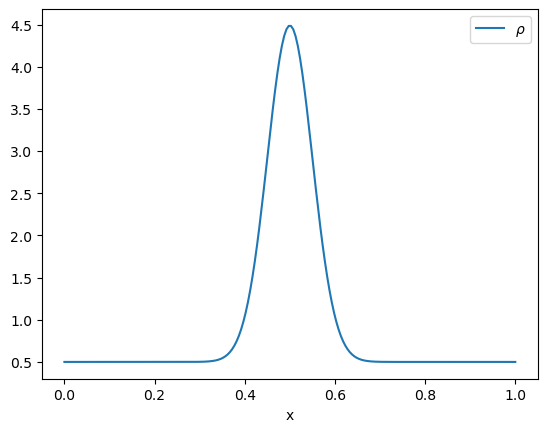

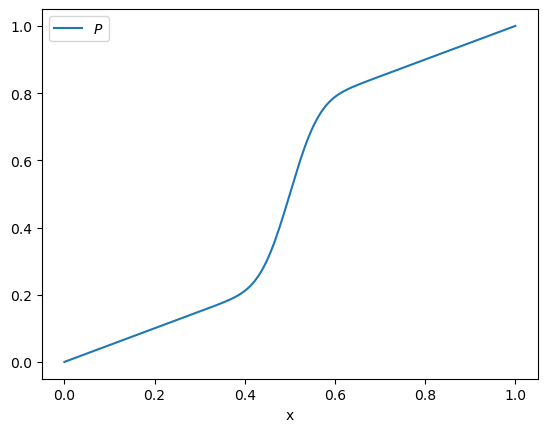

In [12]:
def rho(x, fs, mu, sigma):
    return fs * st.norm.pdf(x, mu, sigma) + (1 - fs)


def P(x, fs, mu, sigma):
    return fs * st.norm.cdf(x, mu, sigma) + (1 - fs) * x

def expected(xe, N, fs, mu, sigma):
    return np.diff(P(xe, fs, mu, sigma)) * N


def chi2(ntot, w, n, xe, fs, mu, sigma):
    mu = expected(xe, ntot, fs, mu, sigma)
    return np.sum(w * (n - mu) ** 2)

xm = np.linspace(0, 1, 200)
plt.figure()
plt.plot(xm, rho(xm, 0.5, mu_true, sigma_true), label=r"$\rho$")
plt.xlabel("x")
plt.legend()
plt.figure()
plt.xlabel("x")
plt.plot(xm, P(xm, 0.5, mu_true, sigma_true), label="$P$")
plt.legend();

In [11]:
def expected(xe, N, fs, mu, sigma):
    return np.diff(P(xe, fs, mu, sigma)) * N


def chi2(ntot, w, n, xe, fs, mu, sigma):
    mu = expected(xe, ntot, fs, mu, sigma)
    return np.sum(w * (n - mu) ** 2)

---

### 2.3

Minimize the $\chi^2$ function iteratively. In the first step use constants weights $w_k = 1$ for all bins, then $w_k = 1/\mu_k$, where $\mu_k$ is estimated using the parameters from the previous fit.   
Stop iterating when the relative change in the estimated parameters after a step becomes less than $10^{-5}$.

Use the function `minimize` from `scipy.optimize` to perform the minimization numerically in each step.   
To avoid unphysical parameter values, you need to use the `bounds` attribute to impose the following limits:
* $f_s \in [0.1, 0.9]$
* $\mu \in [0.3, 0.7]$
* $\sigma \in [0.01, 0.2]$

---

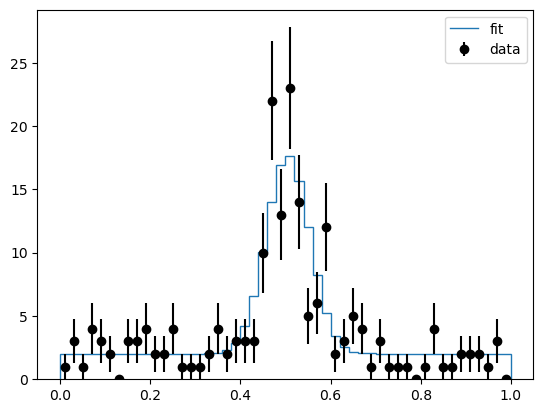

In [26]:
start = (0.3, 0.4, 0.1)

bounds = ((0.1, 0.9), (0.3, 0.7), (0.01, 0.2))

def fit(ntot, n, xe):
    w = 1
    result = minimize(lambda params: chi2(ntot, w, n, xe, *params), start, bounds=bounds)
    param = result.x

    for iteration in range(100):
        mu = expected(xe, ntot, *param)
        w = 1/mu
        result = minimize(lambda params: chi2(ntot, w, n, xe, *params), param, bounds=bounds)
        param_new = result.x
        # print(iteration, param_new)

        if np.all(np.abs(param_new - param) < 1e-5 * param_new):
            break

        param = param_new
        
    return param


param = fit(ntot, n, xe)

plt.errorbar(cx, n, n**0.5, fmt="ok", label="data");
plt.stairs(expected(xe, ntot, *param), xe, label="fit")
plt.legend()
None

---
### 2.4

Repeat the fits with 100 independent samples to get the distribution of the parameter $f_s$.

Is the $f_s$ distributed biased?

---

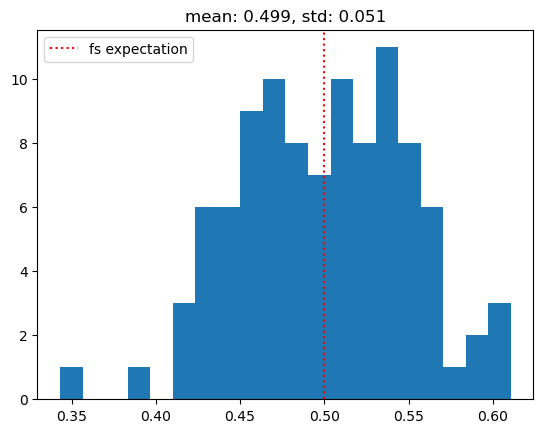

In [23]:
fs = []

for _ in range(100):
    x = generate(rng, mu_true, sigma_true)
    ntot, n, xe = generate_histogram(x)
    param = fit(ntot, n, xe)
    fs.append(param[0])

plt.hist(fs, bins=20)
plt.axvline(0.5, ls=":", color="r", label="fs expectation")
plt.title(f"mean: {np.mean(fs):.3f}, std: {np.std(fs):.3f}")
plt.legend()
None

---
### 2.5 (Bonus)

Repeat [2.4](#2.4), but this time do not iterate the weighted fit. Instead do only two steps. In the first step, compute the result with constant weights equal to 1. In the second step, compute the weights $1/\mu_k$ from the current parameters passed to the $\chi^2$ function.

Is the $f_s$ distribution biased now?

---

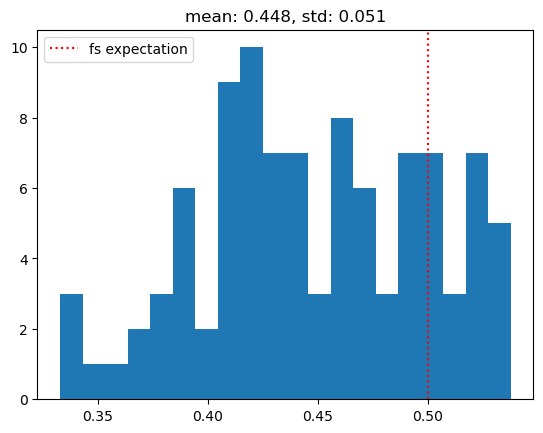

In [27]:
def fit_alternative(ntot, n, xe):
    w = 1
    result = minimize(lambda params: chi2(ntot, w, n, xe, *params), start, bounds=bounds)
    param = result.x

    def cost(params):
        mu = expected(xe, ntot, *params)
        w = 1/mu
        return chi2(ntot, w, n, xe, *params)
    
    result = minimize(cost, param, bounds=bounds)
    param_new = result.x
    # print(iteration, param_new)


    param = param_new
        
    return param


fs = []

for _ in range(100):
    x = generate(rng, mu_true, sigma_true)
    ntot, n, xe = generate_histogram(x)
    param = fit_alternative(ntot, n, xe)
    fs.append(param[0])

plt.hist(fs, bins=20)
plt.axvline(0.5, ls=":", color="r", label="fs expectation")
plt.title(f"mean: {np.mean(fs):.3f}, std: {np.std(fs):.3f}")
plt.legend()
None